## Detección de autos usando SVM y Bag of Words con descriptores SIFT

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-09-Deteccion-SIFT-BoW.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Los datos que se utilizará son el dataset llamado CarData (los datos originales provienen de [aquí](https://cogcomp.seas.upenn.edu/Data/Car/).

In [2]:
!wget -q https://github.com/gcr/arc-evaluator/raw/master/CarData.tar.gz
!tar -xf CarData.tar.gz

!wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/car.jpg

## BoW y Entrenamiento

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

nclusters = 15
bow_kmeans_trainer = cv2.BOWKMeansTrainer(nclusters)

In [3]:
n_bow = 40

for i in range(n_bow):
    # Lectura de la imagen positiva y negativa
    Ipos = cv2.imread('CarData/TrainImages/pos-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    Ineg = cv2.imread('CarData/TrainImages/neg-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    # Extracción de descriptores SIFT
    keypoints_pos, descriptores_pos = sift.detectAndCompute(Ipos, None)
    keypoints_neg, descriptores_neg = sift.detectAndCompute(Ineg, None)
    # Añadir descriptores al entrenador de vocabulario de BoW
    if descriptores_pos is not None:
        bow_kmeans_trainer.add(descriptores_pos)
    if descriptores_neg is not None:
        bow_kmeans_trainer.add(descriptores_neg)

bow_centroids = bow_kmeans_trainer.cluster()

In [4]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = {}
flann = cv2.FlannBasedMatcher(index_params, search_params)

bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

In [5]:
bow_extractor.setVocabulary(bow_centroids)

In [6]:
n_training = 400

training_data = []
training_labels = []

for i in range(n_training):
    # Para imágenes positivas (autos)
    pos_img = cv2.imread('CarData/TrainImages/pos-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    features = sift.detect(pos_img)
    # Histograma BoW utilizando el vocabulario visual previamente obtenido
    pos_descriptors = bow_extractor.compute(pos_img, features)
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)

    # Para imágenes negativas (no autos)
    neg_img = cv2.imread('CarData/TrainImages/neg-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    features = sift.detect(neg_img)
    # Histograma BoW utilizando el vocabulario visual previamente obtenido
    neg_descriptors = bow_extractor.compute(neg_img, features)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(0)

In [7]:
# Conversión de los datos de entrenamiento de lista a arreglos de Numpy
Xtrain = np.array(training_data)
ytrain = np.array(training_labels)

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instancia de SVM con kernel RBF
svm = SVC(kernel='rbf')

# Entrenamiento usando el SVM
svm.fit(Xtrain, ytrain);

In [35]:
# Predicciones (auto/no auto) en el conjunto de entrenamiento
ytrain_predicted = svm.predict(Xtrain)

# Exactitud en el conjunto de entrenamiento
acc_train = accuracy_score(ytrain_predicted, ytrain)

print('Exactitud en el conjunto de entrenamiento para el SVM lineal:', round(acc_train, 4))

Exactitud en el conjunto de entrenamiento para el SVM lineal: 0.8473


## Evaluación

In [36]:
def pyramid(img, scale_factor=1.25, min_size=(200, 80), max_size=(600, 600)):
    h, w = img.shape
    min_w, min_h = min_size
    max_w, max_h = max_size
    while w >= min_w and h >= min_h:
        if w <= max_w and h <= max_h:
            yield img
        w /= scale_factor
        h /= scale_factor
        img = cv2.resize(img, (int(w), int(h)), interpolation=cv2.INTER_AREA)

def sliding_window(img, step=20, window_size=(100, 40)):
    img_h, img_w = img.shape
    window_w, window_h = window_size
    for y in range(0, img_w, step):
        for x in range(0, img_h, step):
            roi = img[y:y+window_h, x:x+window_w]
            roi_h, roi_w = roi.shape
            if roi_w == window_w and roi_h == window_h:
                yield (x, y, roi)


# Non maximum suppression (fast)
# Malisiewicz et al. Python port by Adrian Rosebrock
# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def nms(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]; y1 = boxes[:,1]; x2 = boxes[:,2]; y2 = boxes[:,3]
    scores = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the score/probability of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick]

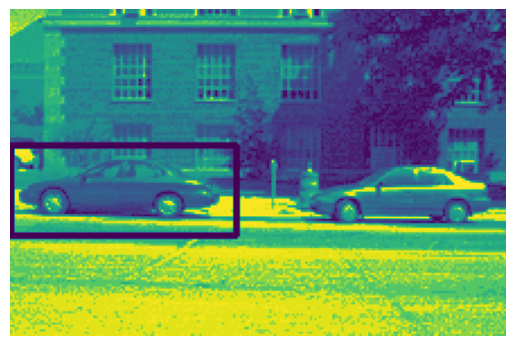

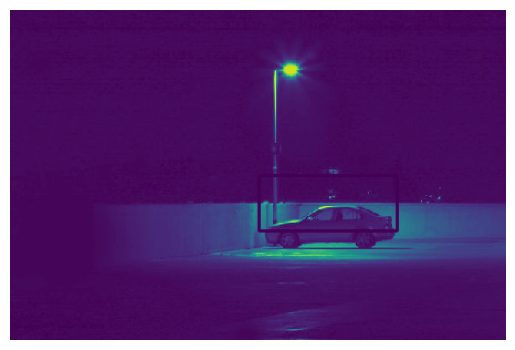

In [44]:
list_img = ['CarData/TestImages/test-7.pgm',
            'car.jpg']

SVM_SCORE_THRESHOLD = 0.8 #0.5
NMS_OVERLAP_THRESHOLD = 0.15

for test_img_path in list_img:
    I = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    pos_rects = []
    for resized in pyramid(I):
        for x, y, Iroi in sliding_window(resized):
            features = sift.detect(Iroi)
            descriptors = bow_extractor.compute(Iroi, features)
            if descriptors is None:
                continue
            prediction = svm.predict(descriptors)
            if prediction.item() == 1.0:
                raw_prediction = svm.decision_function(descriptors)
                score = raw_prediction.item()
                if score > SVM_SCORE_THRESHOLD:
                    h, w = Iroi.shape
                    scale = I.shape[0] / float(resized.shape[0])
                    pos_rects.append([int(x*scale), int(y*scale),
                                      int((x+w)*scale), int((y+h)*scale),
                                      score])
    pos_rects = nms(np.array(pos_rects), NMS_OVERLAP_THRESHOLD)
    for x0, y0, x1, y1, score in pos_rects:
        cv2.rectangle(I, (int(x0), int(y0)), (int(x1), int(y1)), (0, 255, 255), 2)
    plt.imshow(I); plt.axis('off')
    plt.show()
